In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import os
import warnings
warnings.filterwarnings("ignore")

plt.style.use("classic")
sns.set(style="ticks")

SAVE_DIR = "REGRESION-LINEAL"
os.makedirs(SAVE_DIR, exist_ok=True)

In [15]:

df = pd.read_csv(r"../beisbol.csv")

# Eliminar columna índice si existe
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

display(df.head())
print(df.describe(include="all"))

,equipos,bateos,runs
0,Texas,5659,855
1,Boston,5710,875
2,Detroit,5563,787
3,Kansas,5672,730
4,St.,5532,762


        equipos       bateos        runs
count        30    30.000000   30.000000
unique       29          NaN         NaN
top     Chicago          NaN         NaN
freq          2          NaN         NaN
mean        NaN  5523.500000  693.600000
std         NaN    79.873067   82.479088
min         NaN  5417.000000  556.000000
25%         NaN  5448.250000  629.000000
50%         NaN  5515.500000  705.500000
75%         NaN  5575.000000  734.000000
max         NaN  5710.000000  875.000000


In [16]:
# Variables: runs ~ bateos
X = df[["bateos"]].copy()
y = df["runs"].copy()

# Train/Test split (semilla fija para reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((24, 1), (6, 1))

In [17]:
# Pipeline: PolynomialFeatures -> StandardScaler -> Modelo
pipe = Pipeline(steps=[
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Rejillas separadas para cada modelo
param_grid = [
    {
        "poly__degree": [1, 2, 3],
        "model": [LinearRegression()]
    },
    {
        "poly__degree": [1, 2, 3],
        "model": [Ridge(max_iter=10000)],
        "model__alpha": np.logspace(-4, 3, 10)
    },
    {
        "poly__degree": [1, 2, 3],
        "model": [Lasso(max_iter=10000)],
        "model__alpha": np.logspace(-4, 3, 10)
    }
]

In [18]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    refit=True,
    verbose=1
)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor R² (CV):", grid.best_score_)
best_model = grid.best_estimator_
best_model

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Mejores parámetros: {'model': Ridge(max_iter=10000), 'model__alpha': np.float64(4.641588833612782), 'poly__degree': 3}
Mejor R² (CV): 0.21101439835023883


,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


Test -> R² = -0.4862, RMSE = 71.5017


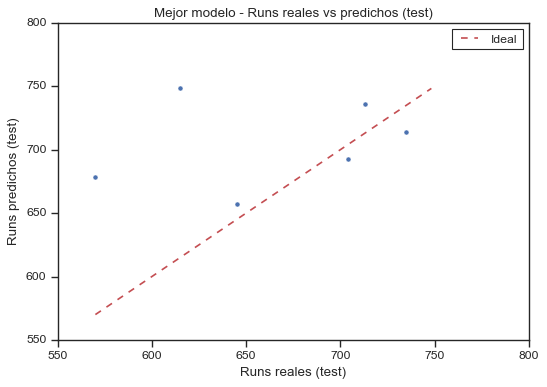

In [10]:
# Predicciones en test
y_pred_test = best_model.predict(X_test)

# Métricas en test
r2 = r2_score(y_test, y_pred_test)
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test -> R² = {r2:.4f}, RMSE = {rmse:.4f}")

# Scatter real vs predicho (test)
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred_test)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal")
plt.xlabel("Runs reales (test)")
plt.ylabel("Runs predichos (test)")
plt.title("Mejor modelo - Runs reales vs predichos (test)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "output_7_0.png"), dpi=300, bbox_inches="tight")
plt.show()

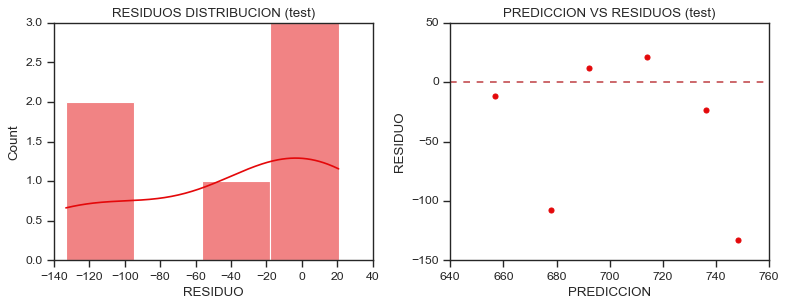

In [19]:
residuos = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Histograma de residuos
sns.histplot(residuos, kde=True, ax=axes[0], color="#E4080A")
axes[0].set_title("RESIDUOS DISTRIBUCION (test)")
axes[0].set_xlabel("RESIDUO")
axes[0].set_ylabel("Count")

# Residuos vs Predicción
axes[1].scatter(y_pred_test, residuos, color="#E4080A")
axes[1].axhline(0, color="r", linestyle="--")
axes[1].set_title("PREDICCION VS RESIDUOS (test)")
axes[1].set_xlabel("PREDICCION")
axes[1].set_ylabel("RESIDUO")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "output_8_0.png"), dpi=300, bbox_inches="tight")
plt.show()

Base (dataset completo) -> R² = 0.3729, RMSE = 64.22


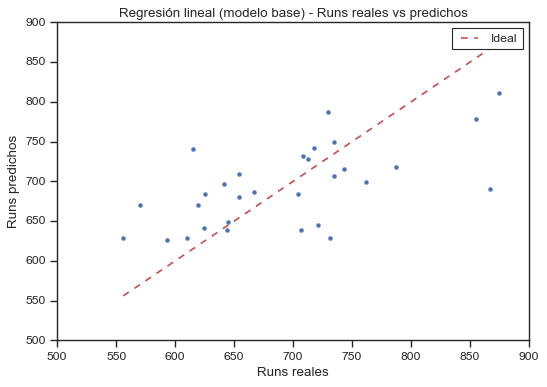

In [12]:
# Modelo base: PolynomialFeatures grado=1 + LinearRegression (sin GridSearchCV)
base_model = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression()),
])

# Para reproducir la figura del informe con "muchos puntos",
# entrenamos y graficamos sobre TODO el dataset.
base_model.fit(X, y)
y_pred_all = base_model.predict(X)

# Métricas sobre todo el conjunto (referencia visual; no es evaluación en test)
r2_all = r2_score(y, y_pred_all)
rmse_all = sqrt(mean_squared_error(y, y_pred_all))
print(f"Base (dataset completo) -> R² = {r2_all:.4f}, RMSE = {rmse_all:.2f}")

plt.figure(figsize=(7,5))
sns.scatterplot(x=y, y=y_pred_all)
min_val = min(y.min(), y_pred_all.min())
max_val = max(y.max(), y_pred_all.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal")
plt.xlabel("REAL RUNS")
plt.ylabel("RUNS PREDICHOS")
plt.title("Regresión lineal (modelo base) - Runs reales vs predichos")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "beisbol_base_modelo.png"), dpi=300, bbox_inches="tight")
plt.show()

In [13]:
base_model.fit(X_train, y_train)
y_pred_train = base_model.predict(X_train)
r2_tr = r2_score(y_train, y_pred_train)
rmse_tr = sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Base (train) -> R² = {r2_tr:.4f}, RMSE = {rmse_tr:.2f}")

y_pred_test_base = base_model.predict(X_test)
r2_te = r2_score(y_test, y_pred_test_base)
rmse_te = sqrt(mean_squared_error(y_test, y_pred_test_base))
print(f"Base (test) -> R² = {r2_te:.4f}, RMSE = {rmse_te:.2f}")

Base (train) -> R² = 0.4428, RMSE = 62.81
Base (test) -> R² = -0.5175, RMSE = 72.25
